In [31]:
import pandas as pd
import glob
import statsmodels.api as sm
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

In [32]:
archivos = glob.glob('dataset/*.csv') #agrupo todos los csv
archivos_ordenados = sorted(archivos, key=lambda x: x.split('_')[3]) #ordeno por YYYMM de forma asc

In [33]:
dataframes = []
for archivo in archivos_ordenados: # junto todos los csv
    df = pd.read_csv(archivo, header=None, sep=';')
    dataframes.append(df)

data = pd.concat(dataframes, ignore_index=True)

nombres_columnas = ['ID', 'Date', 'Consumo', 'Flag', 'Muestra', 'Nombre_Interruptor']
data.columns = nombres_columnas + list(range(len(nombres_columnas), len(data.columns)))

In [34]:
def remove_timezone(date_str):
    return re.sub(r'\s*[-+]\d{4}', '', date_str)
data["Date"] = data["Date"].apply(remove_timezone)
data["Date"] = pd.to_datetime(data["Date"], format="%Y-%m-%d %H:%M:%S")

In [35]:
valores_faltantes = data.isnull().sum()
proporcion_faltantes = valores_faltantes / len(data) * 100
print("Valores faltantes por columna:")
print(proporcion_faltantes)

# Identificar las columnas con valores faltantes
columnas_con_faltantes = valores_faltantes[valores_faltantes > 0].index.tolist()
print("\nColumnas con valores faltantes:")
print(columnas_con_faltantes)

# Evaluar el impacto de los valores faltantes en tu análisis
# Aquí puedes realizar análisis específicos para cada columna con valores faltantes y determinar su importancia

# Considerar estrategias para manejar los valores faltantes
# Por ejemplo, puedes imputar los valores faltantes con la media o la mediana de la columna, eliminar filas con valores faltantes, etc.
# Aquí hay un ejemplo de imputación de valores faltantes con la media de la columna "columna_con_faltantes":
datos_imputados = data.copy()
for columna in columnas_con_faltantes:
    media = data[columna].mean()
    datos_imputados[columna].fillna(media, inplace=True)

Valores faltantes por columna:
ID                    0.0
Date                  0.0
Consumo               0.0
Flag                  0.0
Muestra               0.0
Nombre_Interruptor    0.0
dtype: float64

Columnas con valores faltantes:
[]


In [36]:
data.head(10)

,ID,Date,Consumo,Flag,Muestra,Nombre_Interruptor
0,177760211,2017-02-28 15:00:00,-28.206767,1,4,AJAHUEL 110 H1 P
1,395102211,2017-02-28 15:00:00,-236.467353,1,4,BUIN 110 HT1 MTP
2,395684211,2017-02-28 15:00:00,126.075465,1,4,BUIN 110 H2 P
3,397670211,2017-02-28 15:00:00,81.017303,1,4,LOSALME 110 H1 P
4,397693211,2017-02-28 15:00:00,69.876691,1,4,LOSALME 110 H3 P
5,397712211,2017-02-28 15:00:00,74.248916,1,4,LOSALME 110 H4 P
6,400203211,2017-02-28 15:00:00,30.345499,1,4,LOSALME 110 H2 P
7,433388211,2017-02-28 15:00:00,158.178446,1,4,CHENA 110 H1 P
8,393655211,2017-02-28 15:00:00,109.541742,1,4,BUIN 110 H1 P
9,433398211,2017-02-28 15:00:00,129.607846,1,4,CHENA 110 H2 P


In [37]:
split_data = data['Nombre_Interruptor'].str.split()

data['Barra'] = split_data.str[0]
data['Subestacion'] = split_data.str[1].str.join(' ')
data['Interruptor'] = split_data.str[2:].str.join(' ')

data.drop(columns=['Nombre_Interruptor'], inplace=True)

In [38]:
data

,ID,Date,Consumo,Flag,Muestra,Barra,Subestacion,Interruptor
0,177760211,2017-02-28 15:00:00,-28.206767,1,4,AJAHUEL,1 1 0,H1 P
1,395102211,2017-02-28 15:00:00,-236.467353,1,4,BUIN,1 1 0,HT1 MTP
2,395684211,2017-02-28 15:00:00,126.075465,1,4,BUIN,1 1 0,H2 P
3,397670211,2017-02-28 15:00:00,81.017303,1,4,LOSALME,1 1 0,H1 P
4,397693211,2017-02-28 15:00:00,69.876691,1,4,LOSALME,1 1 0,H3 P
...,...,...,...,...,...,...,...,...
2242963,387377211,2023-06-27 23:00:00,9.554752,1,4,FLORIDA,1 1 0,H3 P
2242964,387401211,2023-06-27 23:00:00,-24.972685,1,4,FLORIDA,1 1 0,H4 P
2242965,392490211,2023-06-27 23:00:00,-39.438634,1,4,FLORIDA,1 1 0,H8 P
2242966,392509211,2023-06-27 23:00:00,37.972639,1,4,FLORIDA,1 1 0,H7 P


In [39]:
# Verificar la consistencia de los datos en cada columna
consistencia_columnas = data.apply(lambda x: x.nunique())
print("Número de valores únicos por columna:")
print(consistencia_columnas)


Número de valores únicos por columna:
ID                  39
Date             55296
Consumo        1970970
Flag                 3
Muestra              5
Barra                7
Subestacion          1
Interruptor         12
dtype: int64


In [40]:
# Realizar análisis estadístico para identificar datos atípicos
analisis_estadistico = data.describe()
print("Análisis estadístico de los datos:")
print(analisis_estadistico)


Análisis estadístico de los datos:
                 ID                           Date       Consumo  \
count  2.242968e+06                        2242968  2.242968e+06   
mean   3.617996e+08  2020-05-25 17:45:27.354291456  3.233541e+01   
min    1.777602e+08            2017-02-28 15:00:00 -5.970000e+02   
25%    2.255402e+08            2018-10-21 05:45:00 -3.062436e+00   
50%    3.925612e+08            2020-06-11 06:30:00  4.379763e+01   
75%    4.333882e+08            2022-02-05 23:15:00  8.145555e+01   
max    8.546412e+08            2023-06-27 23:00:00  3.199903e+02   
std    1.257530e+08                            NaN  7.411118e+01   

               Flag       Muestra  
count  2.242968e+06  2.242968e+06  
mean   9.889330e-01  3.940358e+00  
min    0.000000e+00  0.000000e+00  
25%    1.000000e+00  4.000000e+00  
50%    1.000000e+00  4.000000e+00  
75%    1.000000e+00  4.000000e+00  
max    3.300000e+01  4.000000e+00  
std    5.571145e-01  4.551701e-01  


In [41]:
valor_minimo = data['Consumo'].min()
print(f'Valor Mínimo: {valor_minimo}')
valor_maximo = data['Consumo'].max()
print(f'Valor Máximo: {valor_maximo}')
columna_especifica = data['Consumo']
rangos_validos = (data['Consumo'] >= valor_minimo) & (data['Consumo'] <= valor_maximo)
datos_inconsistentes = data[~rangos_validos]
print(f'Datos columna Consumo:')
print(columna_especifica)
print(f'Datos inconsistentes: {datos_inconsistentes}')
print('\n')

Valor Mínimo: -597.0
Valor Máximo: 319.990285
Datos columna Consumo:
0          -28.206767
1         -236.467353
2          126.075465
3           81.017303
4           69.876691
              ...    
2242963      9.554752
2242964    -24.972685
2242965    -39.438634
2242966     37.972639
2242967     -0.113527
Name: Consumo, Length: 2242968, dtype: float64
Datos inconsistentes: Empty DataFrame
Columns: [ID, Date, Consumo, Flag, Muestra, Barra, Subestacion, Interruptor]
Index: []




In [42]:
consumo = data.groupby(['Barra', 'Date'])['Consumo'].sum().reset_index()
#consumo=consumo.set_index("Fecha_Hora")

In [43]:
consumo

,Barra,Date,Consumo
0,AJAHUEL,2017-02-28 15:00:00,179.705306
1,AJAHUEL,2017-02-28 16:00:00,184.789336
2,AJAHUEL,2017-02-28 17:00:00,187.619336
3,AJAHUEL,2017-02-28 18:00:00,182.389885
4,AJAHUEL,2017-02-28 19:00:00,173.051792
...,...,...,...
387067,LOSALME,2023-06-27 19:00:00,216.470914
387068,LOSALME,2023-06-27 20:00:00,213.860067
387069,LOSALME,2023-06-27 21:00:00,209.034960
387070,LOSALME,2023-06-27 22:00:00,199.870564


In [44]:
# Calcular el rango intercuartílico (IQR)
Q1 = consumo['Consumo'].quantile(0.25)
Q3 = consumo['Consumo'].quantile(0.75)
IQR = Q3 - Q1

# Calcular los límites inferior y superior para identificar outliers
lower_bound = Q1 - 2.0 * IQR
upper_bound = Q3 + 2.0 * IQR

# Filtrar el dataset para excluir outliers
without_me = consumo[(consumo['Consumo'] >= lower_bound) & (consumo['Consumo'] <= upper_bound)]


In [45]:
without_me.info()

<class 'pandas.core.frame.DataFrame'>
Index: 384738 entries, 0 to 387071
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   Barra    384738 non-null  object        
 1   Date     384738 non-null  datetime64[ns]
 2   Consumo  384738 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 11.7+ MB


In [46]:
entrenamiento=consumo.query("Date.dt.year>2017 and Date.dt.year<2022")
validacion=consumo.query("Date.dt.year==2022")

In [47]:
#sin outlayers
train_out=without_me.query("Date.dt.year>2017 and Date.dt.year<2022")
test_out=without_me.query("Date.dt.year==2022")

In [48]:
entrenamiento["Date"]=pd.to_datetime(entrenamiento["Date"],format="%Y-%m-%d %H:%M:%S")
ds_train=entrenamiento.set_index("Date")

validacion["Date"]=pd.to_datetime(validacion["Date"],format="%Y-%m-%d %H:%M:%S")
ds_test=validacion.set_index("Date")

<ipython-input-48-0bd81b097536>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  entrenamiento["Date"]=pd.to_datetime(entrenamiento["Date"],format="%Y-%m-%d %H:%M:%S")
<ipython-input-48-0bd81b097536>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validacion["Date"]=pd.to_datetime(validacion["Date"],format="%Y-%m-%d %H:%M:%S")


In [49]:
ds_train

,Barra,Consumo
Date,,
2018-01-01 00:00:00,AJAHUEL,137.330840
2018-01-01 01:00:00,AJAHUEL,124.045549
2018-01-01 02:00:00,AJAHUEL,118.137811
2018-01-01 03:00:00,AJAHUEL,107.899499
2018-01-01 04:00:00,AJAHUEL,100.362069
...,...,...
2021-12-31 19:00:00,LOSALME,168.644175
2021-12-31 20:00:00,LOSALME,171.593959
2021-12-31 21:00:00,LOSALME,160.167061


In [50]:
#sin outlayers
train_out["Date"]=pd.to_datetime(train_out["Date"],format="%Y-%m-%d %H:%M:%S")
ds_train_out=train_out.set_index("Date")

test_out["Date"]=pd.to_datetime(test_out["Date"],format="%Y-%m-%d %H:%M:%S")
ds_test_out=test_out.set_index("Date")

<ipython-input-50-8cca01920b76>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_out["Date"]=pd.to_datetime(train_out["Date"],format="%Y-%m-%d %H:%M:%S")
<ipython-input-50-8cca01920b76>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_out["Date"]=pd.to_datetime(test_out["Date"],format="%Y-%m-%d %H:%M:%S")


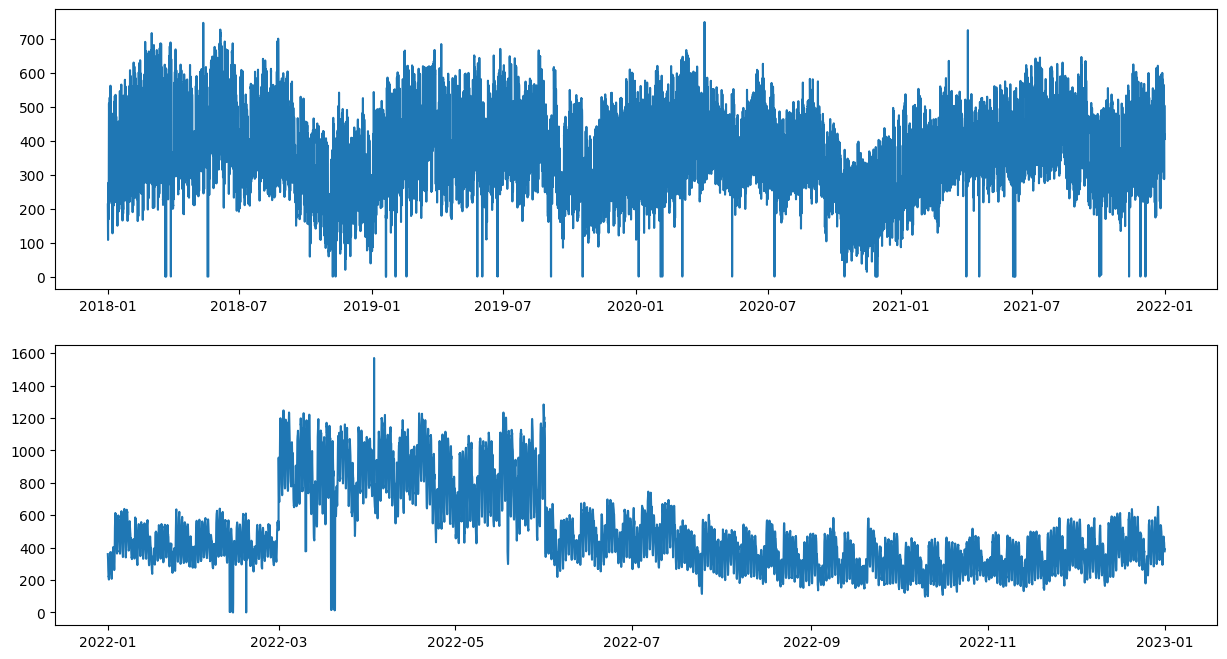

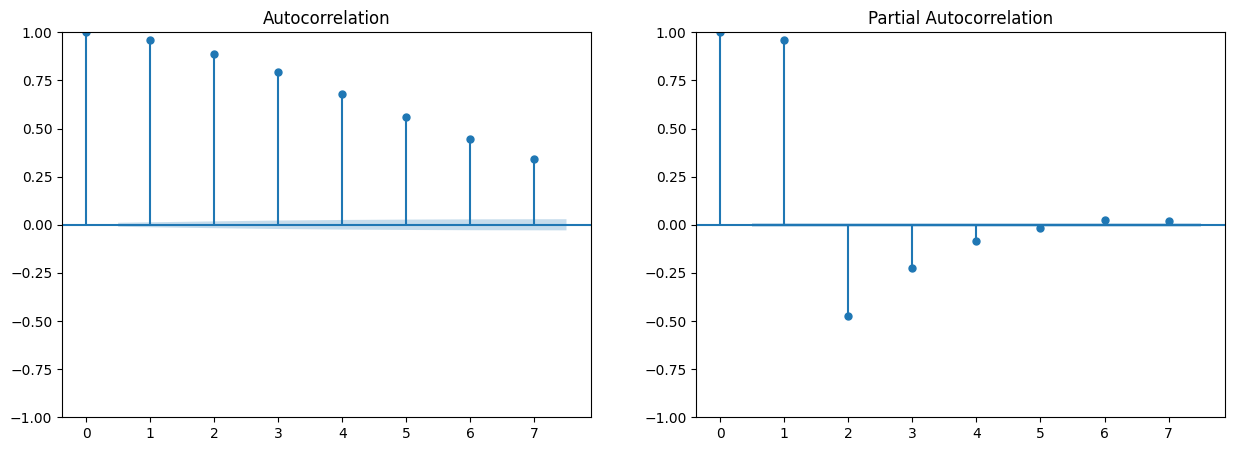

In [51]:
subestacion='ELSALTO'
filtro="Barra=='{0}'".format(subestacion)
y_el_salto=ds_train.query(filtro)["Consumo"]
x_el_salto=ds_train.query(filtro).index
yt_el_salto=ds_test.query(filtro)["Consumo"]
xt_el_salto=ds_test.query(filtro).index
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(x_el_salto,y_el_salto);
axes[1].plot(xt_el_salto,yt_el_salto);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(y_el_salto,lags=7,ax=axes[0]);
plot_pacf(y_el_salto,lags=7,method="ywm",ax=axes[1]);


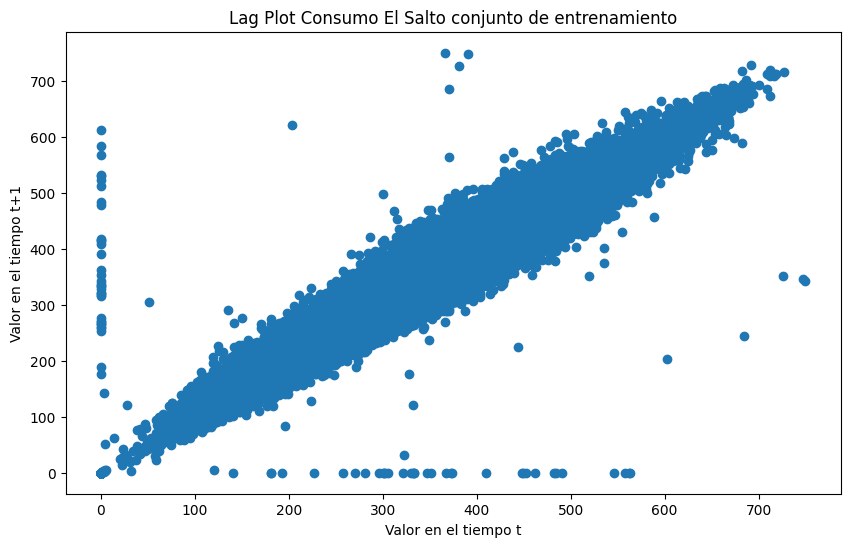

In [52]:
plt.figure(figsize=(10, 6))
lag_plot(y_el_salto, lag=1)  # Puedes ajustar el valor de 'lag' según tus necesidades
plt.title('Lag Plot Consumo El Salto conjunto de entrenamiento')
plt.xlabel('Valor en el tiempo t')
plt.ylabel('Valor en el tiempo t+1')
plt.show()

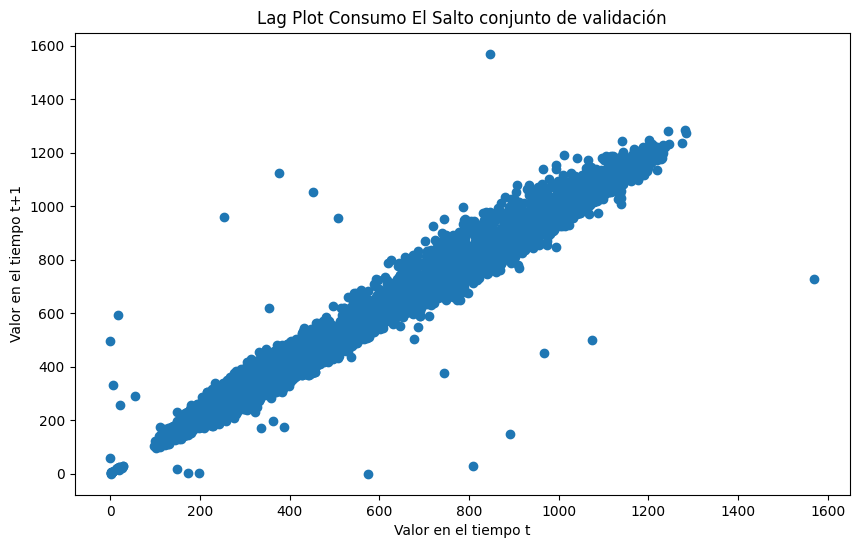

In [53]:
plt.figure(figsize=(10, 6))
lag_plot(yt_el_salto, lag=1)  # Puedes ajustar el valor de 'lag' según tus necesidades
plt.title('Lag Plot Consumo El Salto conjunto de validación')
plt.xlabel('Valor en el tiempo t')
plt.ylabel('Valor en el tiempo t+1')
plt.show()

<Axes: xlabel='Hora', ylabel='Consumo'>

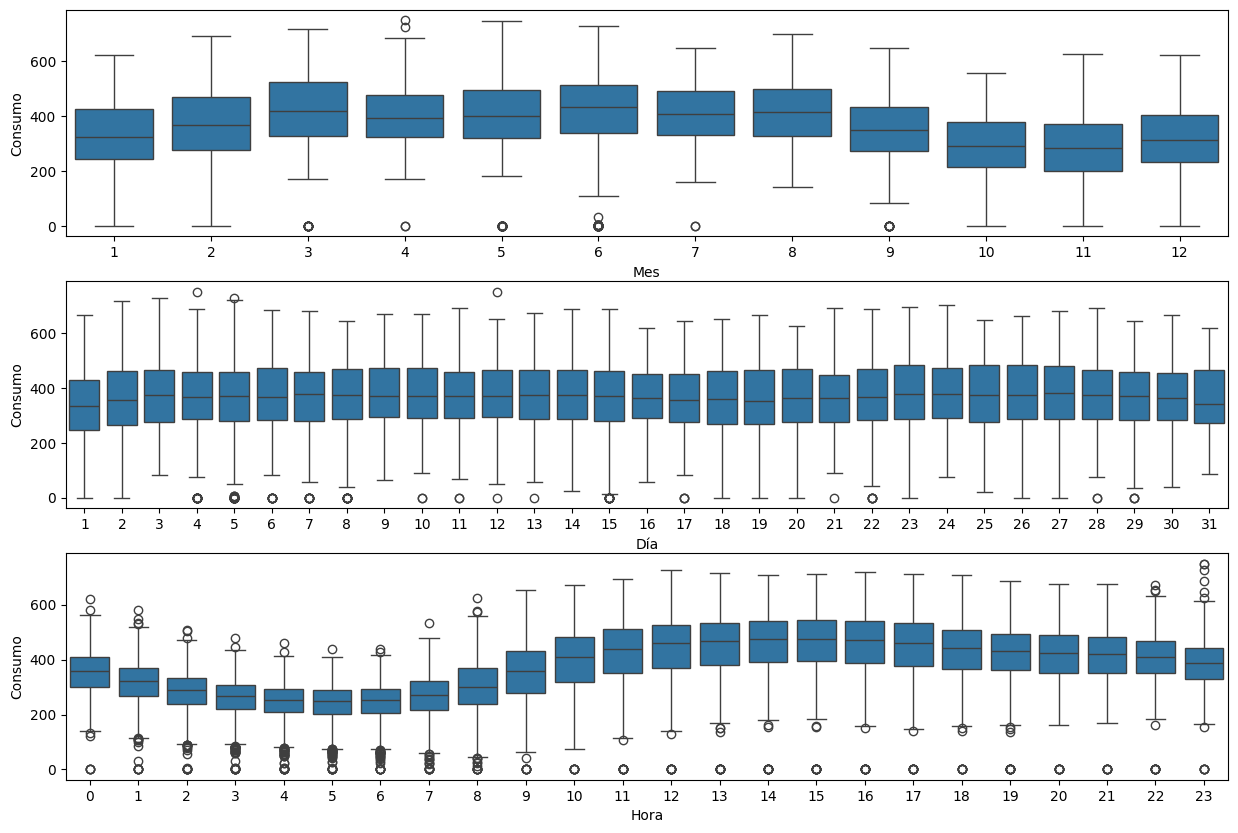

In [54]:
data_el_salto=pd.DataFrame()
data_el_salto["Consumo"]=y_el_salto
data_el_salto["Date"]=y_el_salto.index
data_el_salto["Día"]=data_el_salto["Date"].dt.day
data_el_salto["Hora"]=data_el_salto["Date"].dt.hour
data_el_salto["Mes"]=data_el_salto["Date"].dt.month

fig, axes = plt.subplots(3,1)
fig.set_size_inches(15, 10)

sns.boxplot(x="Mes", y="Consumo", data=data_el_salto, ax=axes[0])
sns.boxplot(x="Día", y="Consumo", data=data_el_salto, ax=axes[1])
sns.boxplot(x="Hora", y="Consumo", data=data_el_salto, ax=axes[2])

In [55]:
data_el_salto["Año"]=data_el_salto["Date"].dt.year
data_el_salto

,Consumo,Date,Día,Hora,Mes,Año
Date,,,,,,
2018-01-01 00:00:00,212.495636,2018-01-01 00:00:00,1,0,1,2018
2018-01-01 01:00:00,200.802108,2018-01-01 01:00:00,1,1,1,2018
2018-01-01 02:00:00,189.173441,2018-01-01 02:00:00,1,2,1,2018
2018-01-01 03:00:00,181.010940,2018-01-01 03:00:00,1,3,1,2018
2018-01-01 04:00:00,168.960606,2018-01-01 04:00:00,1,4,1,2018
...,...,...,...,...,...,...
2021-12-31 19:00:00,431.277752,2021-12-31 19:00:00,31,19,12,2021
2021-12-31 20:00:00,404.119196,2021-12-31 20:00:00,31,20,12,2021
2021-12-31 21:00:00,409.117559,2021-12-31 21:00:00,31,21,12,2021


In [56]:
data_ys_el_salto=data_el_salto[["Año","Mes","Día","Consumo"]].groupby(["Año","Mes","Día"]).agg("mean")
data_ys_el_salto.to_csv("data_ys_el_salto.csv")

In [57]:
data_ys_el_salto

Consumo
Año  Mes Día            
2018 1   1    200.213683
         2    350.595697
         3    378.796207
         4    409.964318
         5    363.742485
...                  ...
2021 12  27   458.721131
         28   490.788343
         29   467.378656
         30   454.214023
         31   405.377118

[1461 rows x 1 columns]

In [58]:
ys_el_salto=[]
xs_el_salto=[]
archivo=open("data_ys_el_salto.csv")
archivo.readline()
for linea in archivo:
    linea=linea.strip().split(",")
    ys_el_salto.append(float(linea[3]))
    fecha=str(linea[0])+"-"+str(linea[1]).zfill(2)+"-"+str(linea[2]).zfill(2)
    xs_el_salto.append(datetime.strptime(fecha,"%Y-%m-%d"))

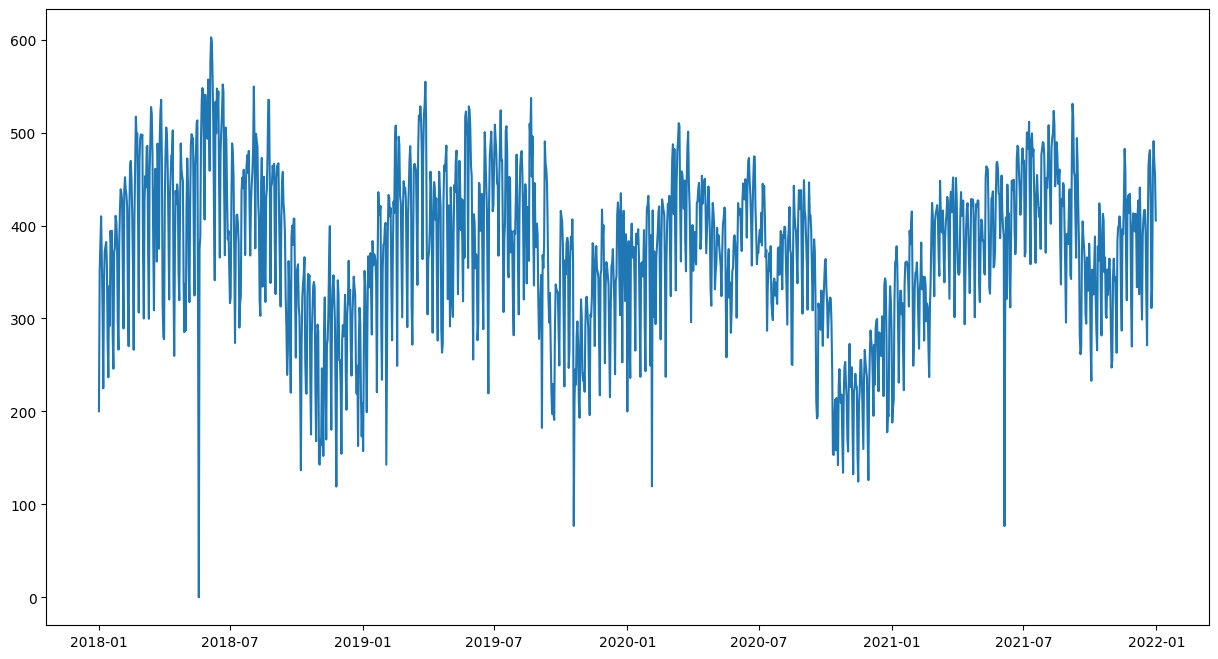

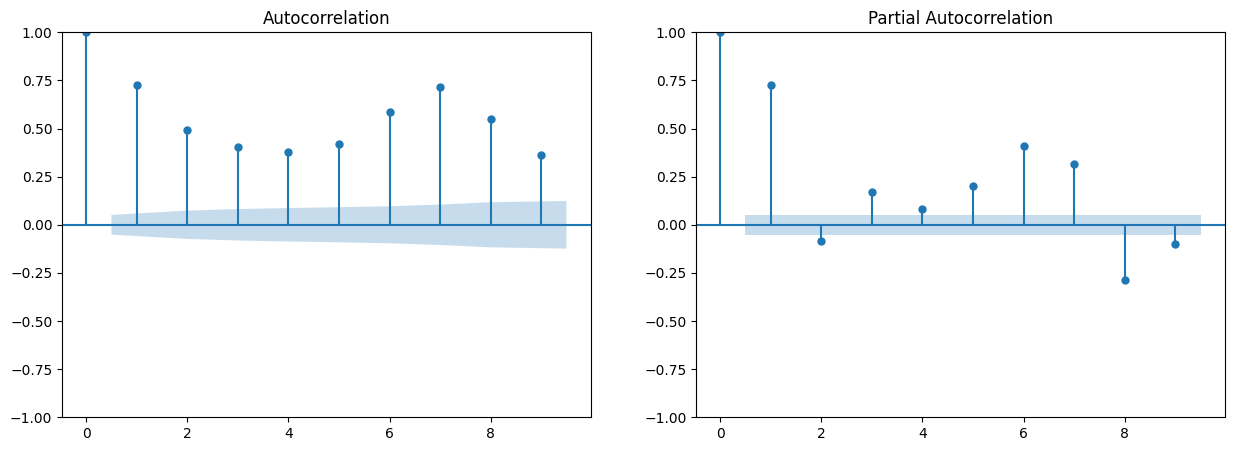

In [59]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 8)
axes.plot(xs_el_salto,ys_el_salto);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(ys_el_salto,lags=9,ax=axes[0]);
plot_pacf(ys_el_salto,lags=9,method="ywm",ax=axes[1]);

In [60]:
result = kpss(ys_el_salto)

# Imprimir los resultados
print('KPSS Statistic:', result[0])
print('p-value:', result[1])
def funcion(x):
    if x<0.05:
        print("La serie no es estacionaria")
    else:
        print("La serie es estacionaria")
funcion(result[1])

KPSS Statistic: 0.3177667034639079
p-value: 0.1
La serie es estacionaria


<ipython-input-60-fe94f374c9d0>:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(ys_el_salto)


**Modelo ARIMA**

In [75]:
modelo_el_salto_d=ARIMA(ys_el_salto,order=(1,0,1))
m_ad1=modelo_el_salto_d.fit()
print("MSE",m_ad1.mse)
print("AIC",m_ad1.aic)
ysp_el_salto=m_ad1.predict()
mape=mean_absolute_percentage_error(ys_el_salto,ysp_el_salto)
print("MAPE",mape)

MSE 3422.278042129735
AIC 16039.990979170729
MAPE 856525728084030.5


In [76]:
"""
#sin outlayers
modelo_el_salto_d_out=ARIMA(ys_el_salto_out,order=(8,0,8))
m_ad1_out=modelo_el_salto_d_out.fit()
print("MSE",m_ad1_out.mse)
print("AIC",m_ad1_out.aic)
ysp_el_salto_out=m_ad1_out.predict()
mape_out=mean_absolute_percentage_error(ys_el_salto_out,ysp_el_salto_out)
print("MAPE",mape_out)
"""

'\n#sin outlayers\nmodelo_el_salto_d_out=ARIMA(ys_el_salto_out,order=(8,0,8))\nm_ad1_out=modelo_el_salto_d_out.fit()\nprint("MSE",m_ad1_out.mse)\nprint("AIC",m_ad1_out.aic)\nysp_el_salto_out=m_ad1_out.predict()\nmape_out=mean_absolute_percentage_error(ys_el_salto_out,ysp_el_salto_out)\nprint("MAPE",mape_out)\n'

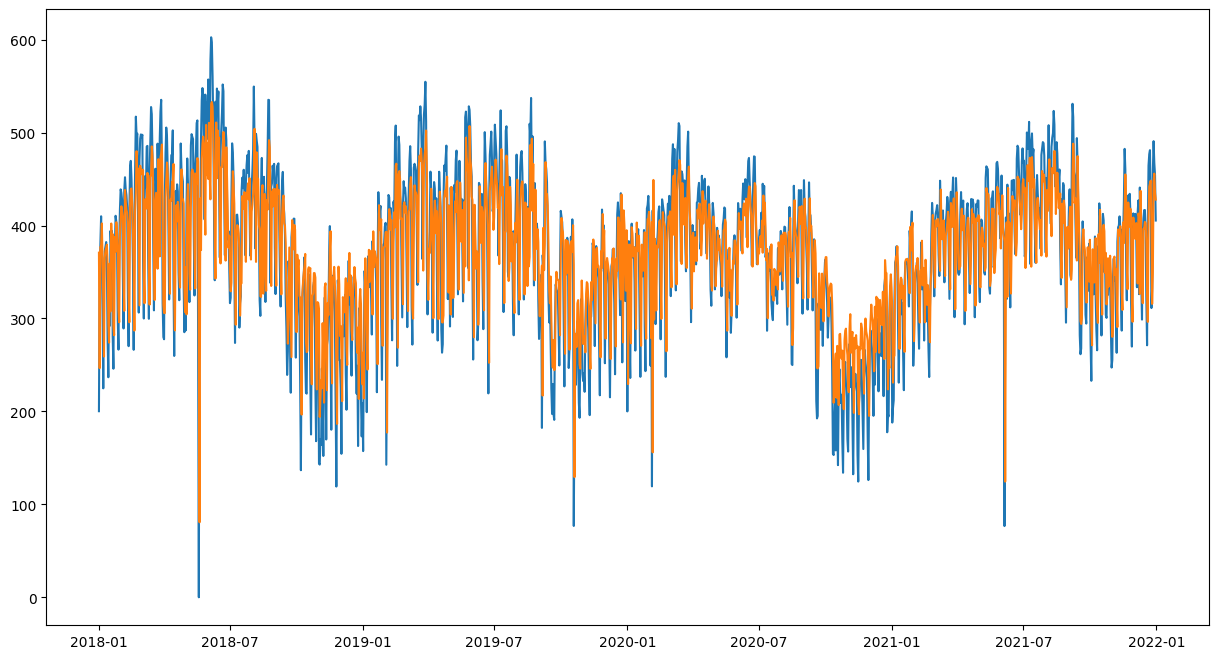

In [77]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 8)
axes.plot(xs_el_salto,ys_el_salto,xs_el_salto,ysp_el_salto);

In [78]:
"""
#sin outlayers
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 8)
axes.plot(xs_el_salto_out,ys_el_salto_out,xs_el_salto_out,ysp_el_salto_out);
"""

'\n#sin outlayers\nfig, axes = plt.subplots(1,1)\nfig.set_size_inches(15, 8)\naxes.plot(xs_el_salto_out,ys_el_salto_out,xs_el_salto_out,ysp_el_salto_out);\n'

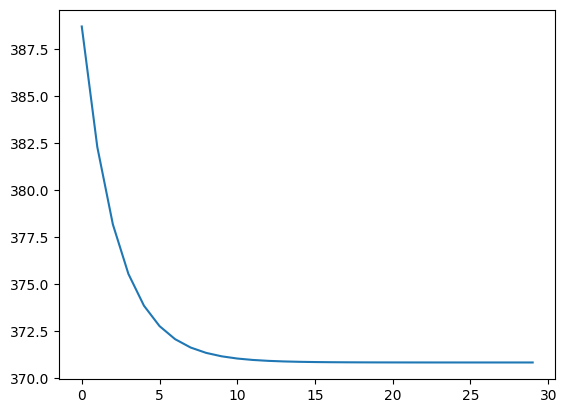

In [79]:
m1_y1_p = m_ad1.get_forecast(steps=30)
m1_y1_ci = m_ad1.conf_int(0.05)
plt.plot(m1_y1_p.predicted_mean)

In [80]:
"""
#sin outlayers
m1_y1_p_out = m_ad1_out.get_forecast(steps=30)
m1_y1_ci_out = m_ad1_out.conf_int(0.05)
plt.plot(m1_y1_p_out.predicted_mean)
"""

'\n#sin outlayers\nm1_y1_p_out = m_ad1_out.get_forecast(steps=30)\nm1_y1_ci_out = m_ad1_out.conf_int(0.05)\nplt.plot(m1_y1_p_out.predicted_mean)\n'

**Modelo Redes Neuronales RNN**

In [188]:
yw_el_salto=[]
yt_el_salto=[]
window=8
for i in range(0,len(ys_el_salto)):
    if i+window < len(ys_el_salto):
        row=[]
        for j in range(window):
            row.append(ys_el_salto[i+j])
        yw_el_salto.append(row)
        yt_el_salto.append(ys_el_salto[i+window])
    else:
        break
print(len(yw_el_salto))

1453


In [189]:
"""
#sin outlayers
yw_el_salto_out=[]
yt_el_salto_out=[]
window=8
for i in range(0,len(ys_el_salto_out)):
    if i+window < len(ys_el_salto_out):
        row=[]
        for j in range(window):
            row.append(ys_el_salto_out[i+j])
        yw_el_salto_out.append(row)
        yt_el_salto_out.append(ys_el_salto_out[i+window])
    else:
        break
print(len(yw_el_salto_out))
"""

'\n#sin outlayers\nyw_el_salto_out=[]\nyt_el_salto_out=[]\nwindow=8\nfor i in range(0,len(ys_el_salto_out)):\n    if i+window < len(ys_el_salto_out):\n        row=[]\n        for j in range(window):\n            row.append(ys_el_salto_out[i+j])\n        yw_el_salto_out.append(row)\n        yt_el_salto_out.append(ys_el_salto_out[i+window])\n    else:\n        break\nprint(len(yw_el_salto_out))\n'

In [190]:
yw_el_salto=np.asarray(yw_el_salto)
yt_el_salto=np.asarray(yt_el_salto)

In [191]:
"""
#sin outlayers
yw_el_salto_out=np.asarray(yw_el_salto_out)
yt_el_salto_out=np.asarray(yt_el_salto_out)
"""

'\n#sin outlayers\nyw_el_salto_out=np.asarray(yw_el_salto_out)\nyt_el_salto_out=np.asarray(yt_el_salto_out)\n'

In [192]:
import tensorflow as tf
from datetime import datetime
from keras.layers import SimpleRNN, Input, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import random as rd

In [193]:
seed=12122008
rd.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [194]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='mape', patience=40, restore_best_weights=True)

model_el_salto = Sequential()
model_el_salto.add(Input(name="serie",shape=(8,1)))
model_el_salto.add(SimpleRNN(256))
model_el_salto.add(Dense(128))
model_el_salto.add(Dense(1, activation='linear'))
model_el_salto.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_11 (SimpleRNN)   (None, 256)               66048     
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dense_23 (Dense)            (None, 1)                 129       
                                                                 
Total params: 99073 (387.00 KB)
Trainable params: 99073 (387.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [195]:
tag="rnn"+datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer=Adam(learning_rate=1e-3)

callbacks = [tensorboard_callback, early_stopping]
model_el_salto.compile(optimizer="Adam", loss='mse', metrics=['mse','mae','mape'])
rnn = model_el_salto.fit(yw_el_salto, yt_el_salto, batch_size=256, epochs=500, verbose=1, callbacks=callbacks)
model_el_salto.save(log_dir + '/model_{0}.keras'.format(tag))

Epoch 1/500
6/6 [==============================] - 2s 55ms/step - loss: 139276.9219 - mse: 139276.9219 - mae: 363.1368 - mape: 782576.5625
Epoch 2/500
6/6 [==============================] - 0s 40ms/step - loss: 123445.2422 - mse: 123445.2422 - mae: 340.5154 - mape: 17569056.0000
Epoch 3/500
6/6 [==============================] - 0s 39ms/step - loss: 107784.5547 - mse: 107784.5547 - mae: 316.8672 - mape: 36274228.0000
Epoch 4/500
6/6 [==============================] - 0s 43ms/step - loss: 91955.5156 - mse: 91955.5156 - mae: 290.8684 - mape: 63749660.0000
Epoch 5/500
6/6 [==============================] - 0s 38ms/step - loss: 76018.6797 - mse: 76018.6797 - mae: 262.1027 - mape: 67066628.0000
Epoch 6/500
6/6 [==============================] - 0s 40ms/step - loss: 60540.3438 - mse: 60540.3438 - mae: 230.9075 - mape: 91719808.0000
Epoch 7/500
6/6 [==============================] - 0s 40ms/step - loss: 46094.3828 - mse: 46094.3828 - mae: 198.0131 - mape: 130685424.0000
Epoch 8/500
6/6 [=====

46/46 [==============================] - 0s 4ms/step


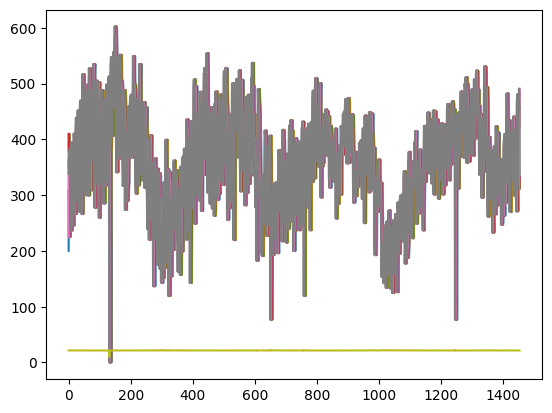

In [196]:
xw_el_salto=[i for i in range(len(yw_el_salto))]
yp_el_salto=model_el_salto.predict(yw_el_salto)
plt.plot(xw_el_salto,yw_el_salto,xw_el_salto,yp_el_salto)

1/1 [==============================] - 0s 36ms/step
21.462122
1/1 [==============================] - 0s 41ms/step
20.910625
1/1 [==============================] - 0s 30ms/step
19.901144
1/1 [==============================] - 0s 41ms/step
19.95688
1/1 [==============================] - 0s 33ms/step
19.96961
1/1 [==============================] - 0s 42ms/step
19.971619
1/1 [==============================] - 0s 33ms/step
19.975761
1/1 [==============================] - 0s 31ms/step
19.972069
1/1 [==============================] - 0s 33ms/step
19.972013
1/1 [==============================] - 0s 38ms/step
19.971775
1/1 [==============================] - 0s 41ms/step
19.97177
1/1 [==============================] - 0s 30ms/step
19.971796
1/1 [==============================] - 0s 42ms/step
19.971794
1/1 [==============================] - 0s 31ms/step
19.9718
1/1 [==============================] - 0s 30ms/step
19.971794
1/1 [==============================] - 0s 34ms/step
19.971792
1/1 [========

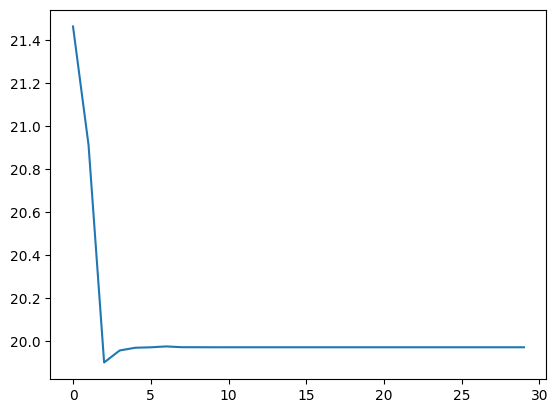

In [197]:
ultimo_el_salto=list(yw_el_salto[-1].copy())
forecasts=[]
for i in range(30):
    data_el_salto=np.array(np.asarray([ultimo_el_salto]))
    forecast=model_el_salto.predict(data_el_salto)
    valor=forecast[0][0]
    print(valor)
    forecasts.append(valor)
    ultimo_el_salto.pop(0)
    ultimo_el_salto.append(valor)
plt.plot(forecasts)

In [198]:
#entrega de datos desordenados
tag="rnn"+datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer=Adam(learning_rate=1e-3)

callbacks = [tensorboard_callback, early_stopping]
model_el_salto.compile(optimizer="Adam", loss='mse', metrics=['mse','mae','mape'])
rnn = model_el_salto.fit(yw_el_salto, yt_el_salto, batch_size=256, epochs=500,shuffle=True,verbose=1,callbacks=callbacks)
model_el_salto.save(log_dir+'/model_{0}.keras'.format(tag))

Epoch 1/500
6/6 [==============================] - 3s 65ms/step - loss: 123137.1484 - mse: 123137.1484 - mae: 340.2006 - mape: 14926699.0000
Epoch 2/500
6/6 [==============================] - 0s 55ms/step - loss: 107169.8750 - mse: 107169.8750 - mae: 315.7393 - mape: 34136384.0000
Epoch 3/500
6/6 [==============================] - 0s 39ms/step - loss: 90923.2422 - mse: 90923.2422 - mae: 289.0497 - mape: 55345908.0000
Epoch 4/500
6/6 [==============================] - 0s 37ms/step - loss: 74846.0312 - mse: 74846.0312 - mae: 259.8788 - mape: 86095424.0000
Epoch 5/500
6/6 [==============================] - 0s 37ms/step - loss: 59341.5547 - mse: 59341.5547 - mae: 228.3144 - mape: 89753656.0000
Epoch 6/500
6/6 [==============================] - 0s 40ms/step - loss: 45083.6641 - mse: 45083.6641 - mae: 195.4444 - mape: 116496712.0000
Epoch 7/500
6/6 [==============================] - 0s 39ms/step - loss: 32630.9297 - mse: 32630.9297 - mae: 162.3386 - mape: 156980096.0000
Epoch 8/500
6/6 [====

46/46 [==============================] - 0s 4ms/step


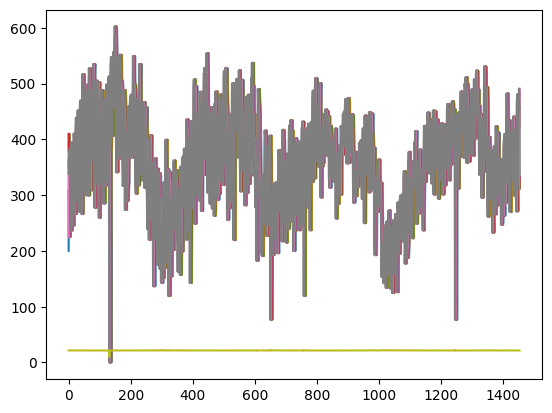

In [199]:
xw_el_salto=[i for i in range(len(yw_el_salto))]
yp=model_el_salto.predict(yw_el_salto)
plt.plot(xw_el_salto,yw_el_salto,xw_el_salto,yp_el_salto)

1/1 [==============================] - 0s 32ms/step
45.54633
1/1 [==============================] - 0s 30ms/step
44.080383
1/1 [==============================] - 0s 34ms/step
43.96819
1/1 [==============================] - 0s 35ms/step
43.98293
1/1 [==============================] - 0s 34ms/step
43.98153
1/1 [==============================] - 0s 37ms/step
43.980793
1/1 [==============================] - 0s 37ms/step
43.980766
1/1 [==============================] - 0s 37ms/step
43.980778
1/1 [==============================] - 0s 36ms/step
43.98077
1/1 [==============================] - 0s 32ms/step
43.98077
1/1 [==============================] - 0s 41ms/step
43.980774
1/1 [==============================] - 0s 32ms/step
43.98077
1/1 [==============================] - 0s 34ms/step
43.98077
1/1 [==============================] - 0s 34ms/step
43.98077
1/1 [==============================] - 0s 36ms/step
43.98077
1/1 [==============================] - 0s 31ms/step
43.98077
1/1 [==============

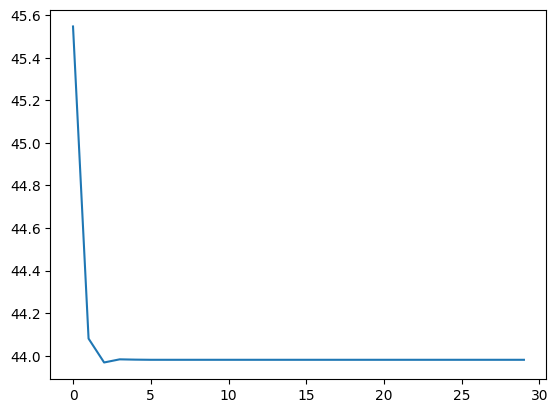

In [200]:
ultimo_el_salto=list(yw_el_salto[-1].copy())
forecasts=[]
for i in range(30):
    data_el_salto=np.array(np.asarray([ultimo_el_salto]))
    forecast=model_el_salto.predict(data_el_salto)
    valor=forecast[0][0]
    print(valor)
    forecasts.append(valor)
    ultimo_el_salto.pop(0)
    ultimo_el_salto.append(valor)
plt.plot(forecasts)

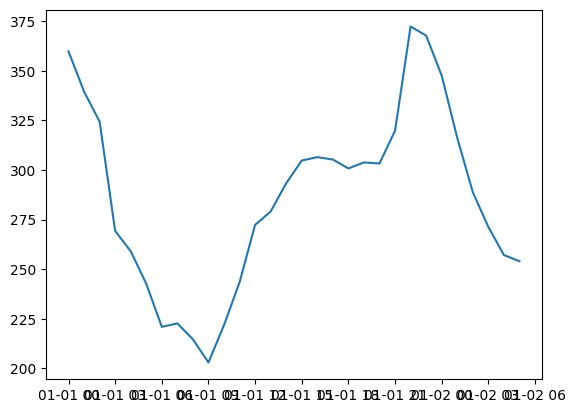

In [201]:
yt_el_salto=ds_test.query(filtro)["Consumo"]
xt_el_salto=ds_test.query(filtro).index
plt.plot(xt_el_salto[:30],yt_el_salto[:30])

**Modelo Percetron Multicapa**

In [202]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Preparar los datos de entrenamiento
X_train = x_el_salto.values.reshape(-1, 1)  # Usar la fecha como característica
y_train = y_el_salto.values.ravel()  # Aplanar y convertir a un arreglo unidimensional

# Crear y entrenar el modelo MLP
model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=1000)
model.fit(X_train, y_train)

X_test = yt_el_salto.values.reshape(-1, 1)  # Usar los datos de 'Consumo' para el conjunto de prueba
predictions = model.predict(X_test)

# Calcular el error cuadrático medio
mse = mean_squared_error(yt_el_salto, predictions)

# Calcular el error absoluto medio
mae = mean_absolute_error(yt_el_salto, predictions)

# Calcular R^2
r2 = r2_score(yt_el_salto, predictions)

# Calcular MAPE
mape = np.mean(np.abs((yt_el_salto - predictions) / yt_el_salto)) * 100

print(f'Error cuadrático medio: {mse}')
print(f'Error absoluto medio: {mae}')
print(f'R^2: {r2}')

Error cuadrático medio: 318690.280251502
Error absoluto medio: 504.7869902921887
R^2: -3.9888471850181526
